In [1]:
!pip install tweepy
!pip install wordcloud
!pip install textblob

In [2]:
# import nltk package
import nltk
from collections import Counter
from wordcloud import WordCloud
from textblob import TextBlob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import json, time, os

# Question A

## 1.The key word of interest is ElonMusk

## 2.Using the Python script the instructor team provided, collect 10K recent tweets on the selected keyword.

### Step1: Collect the tweets from Twitter platform and store them in json file.

In [ ]:
# -*- coding:utf-8 -*-

# @Time    : 2022-09-15
# @Author  : Gene Moo Lee, Jaecheol Park and Xiaoke Zhang
# Disclaimer: Students, please do not redistribute this code outside the class. Thank you!


# Note: These are two wrapper classes for Twitter Collection. You are not required to understand the details in this file.
# Please go to `tweet_collection_example.ipynb` to learn how to use this for tweet collections.


import json, time, os
from datetime import datetime

import tweepy
from tweepy import StreamingClient, StreamRule


class TwitterStreamer(StreamingClient):

    def __init__(self, bearer_token):

        # initiate the StreamingClient
        super().__init__(bearer_token = bearer_token)
        
        # whether to show process
        self.show_process = True
        # store the tracked tweets
        self.tweets = []
        # number of tweets to collect
        self.tweet_num = 10000
        # query
        self.query = ''
        # file save information
        self.save_result = True
        self.save_dir = ''
        # store result 
        self.result = {}
    
    def on_tweet(self, tweet): 
        '''Overwrite the original function to store all returned tweets
        show_process: If true, print the current tweet collected
        '''
        self.tweets.append(tweet.data)

        # print the current tweet if specified
        if self.show_process:
            print("Tweet No."+ str(len(self.tweets)), tweet.text)

        # check if we have collected enough tweets, if so disconnect
        if len(self.tweets) == self.tweet_num:
            self.result = {}
            self.result['collection_type'] = 'streaming'
            self.result['collection_timestamp'] = time.time()
            self.result['query'] = self.query
            self.result['tweet_cnt'] = len(self.tweets)
            self.result['tweets'] = self.tweets

            if self.save_result:
                with open(self.save_file, 'w', encoding = 'utf-8') as w:
                    w.write(json.dumps(self.result, indent=4))

            self.disconnect()
        
    def clear_rule(self):
        '''Clear the existing rules'''
        rules = self.get_rules().data
        if rules:
            for rule in rules:
                self.delete_rules(rule.id)

    def collect_tweets_stream(self, query
                            , tweets_cnt = 10000
                            , show_process = True
                            , save_result = True
                            , save_dir = None 
                            , file_name = None
                            ):
        '''Collecing the tweets from stream. 
        `query`: the search rules. For more information, please see: https://github.com/twitterdev/getting-started-with-the-twitter-api-v2-for-academic-research/blob/main/modules/5-how-to-write-search-queries.md
        `tweet_cnt`: the number of tweets to be collected.
        `show_process`: If true, print the current tweet collected.
        `save_result`: If True, the result will be saved in a json file in the same directory
        `save_dir`: The directory you want to save this file. If not specified, the file will be written in the same directory.
        `file_name`: The file name. If not specified, the file will be named after your searh query and tweet count.
        '''
        try:
            # clear all existing rules
            self.clear_rule()

            # clear the existing data
            self.tweets = []

            # set the number of tweets to collect
            self.tweet_num = tweets_cnt

            # set whether to show process and whether to save_result
            self.show_process = show_process
            self.save_result = save_result

            # specify directory 
            if not file_name:  # file name not specified
                file_name = 'streaming' + query.replace(':','-')+'_'+str(self.tweet_num)+'.json'
            if save_dir:
                if not os.path.exists(save_dir):  # make sure the direcroty exists
                    os.makedirs(save_dir)
                self.save_file = os.path.join(save_dir, file_name)
            else:
                self.save_file = file_name
                
            
            # add rules
            self.query = query
            rule = StreamRule(value = query)
            self.add_rules(rule)

            # start running

            # for more information about expansion: https://developer.twitter.com/en/docs/twitter-api/expansions
            # for more information about tweet_fields: https://developer.twitter.com/en/docs/twitter-api/data-dictionary/object-model/tweet
            self.filter(expansions = 'author_id,referenced_tweets.id,attachments.media_keys,in_reply_to_user_id'
                        , tweet_fields = 'created_at,lang,possibly_sensitive,source,entities,public_metrics')

        except Exception as e:
            print('An Error Occured when running:', e)

    def get_result(self):
        '''return the collected tweets'''
        return self.result



class TwitterCollector():

    def __init__(self, bearer_token):
        self.bearer_token = bearer_token
        self.client = tweepy.Client(bearer_token = self.bearer_token)
        self.ts = TwitterStreamer(bearer_token=self.bearer_token)

    def renew_client(self):
        '''renew the client'''
        self.client = tweepy.Client(bearer_token = self.bearer_token)
    
    def fetch_recent_tweets(self, query
                            , tweets_cnt = 10000
                            , start_time = None
                            , end_time = None
                            , save_result = True
                            , save_dir = None
                            , file_name = None
                            ):
        '''
        Collecing recent tweets up to 7 days.
        `query`: the search rules. For more information, please see: https://github.com/twitterdev/getting-started-with-the-twitter-api-v2-for-academic-research/blob/main/modules/5-how-to-write-search-queries.md
        `tweets_cnt`: the number of tweets to be collected.
        `start_time`: datetime.datetime type, search posts after this time. Must be within 7 days.
        `end_time`: datetime.datetime type, search posts before this time. Must be within 7 days.
        `save_result`: If True, the result will be saved in a json file in the same directory.
        `save_dir`: The directory you want to save this file. If not specified, the file will be written in the same directory.
        `file_name`: The file name. If not specified, the file will be named after your searh query and tweet count.
        '''
        # renew client first
        self.renew_client()

        tweets_info = []
        tweets = tweepy.Paginator(self.client.search_recent_tweets, query = query, max_results = 100
                                , start_time = start_time
                                , end_time = end_time
                                , expansions = ['author_id', 'referenced_tweets.id', 'geo.place_id', 'attachments.media_keys', 'in_reply_to_user_id']
                                , tweet_fields = ['author_id', 'created_at', 'lang', 'possibly_sensitive', 'source', 'geo', 'entities', 'public_metrics', 'context_annotations']
                                , place_fields = ['country', 'country_code', 'geo']
                                ).flatten(tweets_cnt)
        for tweet in tweets:
            tweets_info.append(tweet.data)

        result = {}
        result['collection_type'] = 'recent post'
        result['collection_timestamp'] = time.time()
        result['query'] = query
        result['tweet_cnt'] = len(tweets_info)
        result['tweets'] = tweets_info

        if save_result:
            # specify directory 
            if not file_name:  # file name not specified
                file_name = 'recent_post_' + query.replace(':','-')+'_'+str(tweets_cnt)+'.json'
            else:
                if '.json' not in file_name:
                    file_name = file_name + '.json'
            if save_dir:
                if not os.path.exists(save_dir):  # make sure the direcroty exists
                    os.makedirs(save_dir)
                save_file = os.path.join(save_dir, file_name)
            else:
                save_file = file_name

            with open(save_file, 'w', encoding = 'utf-8') as w:
                w.write(json.dumps(result, indent=4))

        return result

    def fetch_stream_tweets(self, query
                            , tweets_cnt = 10000
                            , show_process = True
                            , save_result = True
                            , save_dir = None
                            , file_name = None
                            ):
        '''Collecing tweets on stream.
        `query`: the search rules. For more information, please see: https://github.com/twitterdev/getting-started-with-the-twitter-api-v2-for-academic-research/blob/main/modules/5-how-to-write-search-queries.md
        `tweets_cnt`: the number of tweets to be collected.
        `show_process`: If True, the tweet collected will be printed in the screen.
        `save_result`: If True, the result will be saved in a json file in the same directory.
        `save_dir`: The directory you want to save this file. If not specified, the file will be written in the same directory.
        `file_name`: The file name. If not specified, the file will be named after your searh query and tweet count.
        '''
        self.ts.collect_tweets_stream(query = query, tweets_cnt = tweets_cnt, show_process = show_process, save_result = save_result, save_dir = save_dir, file_name = file_name)
        result = self.ts.get_result()
        return result


    def fetch_author_info(self, author_id):
        '''Fetch the meta data for the author.
        `author_id`: the id for the author
        '''

        self.renew_client()
        # for more information on user fields: https://developer.twitter.com/en/docs/twitter-api/data-dictionary/object-model/user
        user = self.client.get_user(id = int(author_id)
                            , user_fields = ['created_at', 'description', 'location', 'public_metrics', 'verified'])
        return user.data.data


if __name__ == "__main__":
    bearer_token = r"AAAAAAAAAAAAAAAAAAAAAByGhgEAAAAAbKZqNAwPIZbtYTOwq0dd4fqZowk%3DgEmvnUu92IQ3fVKwFWCQo2W80Zfj1vBrKlZemJ5V3tj2ekrvOL"

    # initiate the class
    tc = TwitterCollector(bearer_token=bearer_token)

    # set up search queries
    #query1 = 'RickandMorty'  # tweets containing the word 'queen'
    query2 = 'Elon Musk'  # tweets containing 'queen' and 'elizabeth' at the same time
    #query3 = 'Nobel Prize or nobel prize' # tweets containing 'queen' or 'elizabeth'
    #query4 = 'Nobel Prize or nobel prize -is:retweet lang:en'  # tweets containing 'queen' or 'elizabeth', written in English, and excluding retweets


    # 1. search for recent tweets posted in the last seven days

    
    # you can also specify the exact time window for tweet collection
    recent_result2 = tc.fetch_recent_tweets(query=query2  # search query
                            , tweets_cnt= 10000  # number of tweets to collect
                            , save_result= True # if True, the result will be atomatically saved to a json file in the current directory for later analysis
                            , start_time = datetime.fromisoformat('2022-09-29 05:19:00')  # starting time for tweet collection, must be within 7 days
                            , end_time = datetime.fromisoformat('2022-10-05 05:19:00')  # ending time for tweet collection, must be within 7 days
                            , save_dir = 'sample_data'  # the file will be saved in this directory
                            , file_name = 'elon.json'  # this will be the file name
                            )
    

    # 2. search for streaming tweets (ongoing tweets)    

    # 3. Here is the structure of the data obtained
    print(type(recent_result2['tweets']))  # streaming result is stored in a list, where each object is one tweet
    print(recent_result2['tweets'][0])  # tweet information is like this


    # 4. We now know the author id for each post. Let's get the author information according to the author id.
    author_id = recent_result2['tweets'][0]['author_id']  # sample one author
    author_info = tc.fetch_author_info(author_id)
    print(author_info)

### Step2: Open the json file for tweets collected and author information collected

In [2]:
with open('sample_data/elon.json') as infile:
    streaming_result = json.load(infile)

In [3]:
with open('sample_data/author_info.json') as infile:
    author_infomation= json.load(infile)

### Step3: Test whether we have collected enough tweets and whether the structure of the data is correct

In [4]:
from pprint import pprint
print(len(streaming_result["tweets"]))
print(streaming_result.keys())
pprint(streaming_result["tweets"][1])

10000
dict_keys(['collection_type', 'collection_timestamp', 'query', 'tweet_cnt', 'tweets'])
{'author_id': '15765206',
 'context_annotations': [{'domain': {'description': 'Categories within Brand '
                                                    'Verticals that narrow '
                                                    'down the scope of Brands',
                                     'id': '46',
                                     'name': 'Business Taxonomy'},
                          'entity': {'description': 'Brands, companies, '
                                                    'advertisers and every '
                                                    'non-person handle with '
                                                    'the profit intent related '
                                                    'to Banks, Credit cards, '
                                                    'Insurance, Investments, '
                                                    'Stocks '

## 3.From the collected tweets, get the list of unique author IDs.

### Use an empty list to contain the IDs and use for loop and append() method to collect IDs from streaming_result

In [5]:
authors_id=[]
for i in range(len(streaming_result["tweets"])):
    authors_id.append(streaming_result["tweets"][i]["author_id"])
uniq_authors_id = []
for i in authors_id:
    if i not in uniq_authors_id:
        uniq_authors_id.append(i)
pprint(authors_id)
pprint(len(uniq_authors_id))

['1872465721',
 '15765206',
 '149483869',
 '348426187',
 '1491937857619038217',
 '2420970732',
 '57150866',
 '1045939006435803136',
 '1512128096173969408',
 '1484095324192923648',
 '936786649941463040',
 '44687177',
 '1574309758420541441',
 '26963802',
 '1379279545401028608',
 '1385165817512222722',
 '2392077660',
 '1573652162810449920',
 '935310144270876672',
 '757543579661328384',
 '936429870799654918',
 '45413198',
 '1881451992',
 '29171042',
 '837560996944195584',
 '286890643',
 '1218657589925269504',
 '798223411503894528',
 '1369005530',
 '2270992435',
 '24399189',
 '1184526866264158208',
 '27498544',
 '1086073375',
 '48243662',
 '1314744405748744192',
 '874593672989470721',
 '1156600511321255943',
 '20190741',
 '1457682405494444034',
 '1049175501338808320',
 '107123611',
 '1138096424661348353',
 '835035278',
 '301746653',
 '1360027525016076290',
 '1242516806994141188',
 '1445896096178323461',
 '1550150574200332288',
 '1543799401',
 '1394905395341189122',
 '166278098',
 '151919699

 '837560996944195584',
 '3273997009',
 '779750301691744256',
 '1367351292839026688',
 '36877829',
 '1562545089184149504',
 '1519506333598371840',
 '2897897840',
 '1520260764572938240',
 '1281450078289432576',
 '1615356464',
 '1109869420799815686',
 '163989580',
 '2260944469',
 '1230562055624765440',
 '110122292',
 '1541040969847816193',
 '1542995574223319040',
 '1492412391400919041',
 '1563905070810697728',
 '2739395681',
 '62414527',
 '4797176777',
 '1105242321031839744',
 '983837662317445127',
 '2174682439',
 '33811812',
 '222586842',
 '259333617',
 '1360497914242609152',
 '1567743730635128832',
 '1518932015852175363',
 '1519268661734780928',
 '1328350025504616448',
 '1144464382857904129',
 '1048914642226094080',
 '1522592969248940032',
 '2152124425',
 '1559402048130793472',
 '1501555406933528579',
 '1356896318',
 '2357056450',
 '1565307732420603904',
 '255018122',
 '3435787115',
 '534720794',
 '362084030',
 '868188828221263873',
 '1488892394548469765',
 '1550475926202249216',
 '4209

 '1513197488894877698',
 '423906673',
 '1206274404633714688',
 '1331607217640931331',
 '93341319',
 '418698206',
 '843874710',
 '1356346449005576192',
 '2392818758',
 '1694505356',
 '147256119',
 '321666397',
 '2599342730',
 '1460624738120724482',
 '1519096876150235139',
 '2719776012',
 '1397486168686555144',
 '60312823',
 '2937946066',
 '1537489129788915712',
 '1178567440294453248',
 '1253764531526021120',
 '375488294',
 '412485461',
 '2321245283',
 '1561433218875883525',
 '822336732121223168',
 '1503657232273190915',
 '210945744',
 '1054435938737287168',
 '1325148870767124481',
 '1724882370',
 '264003031',
 '554159547',
 '1517034266970005504',
 '583117972',
 '738484777976659968',
 '18520624',
 '856288106705821696',
 '2977328077',
 '1290567304032522240',
 '745289439501418496',
 '3688307962',
 '1513426403445850119',
 '248113252',
 '3347290137',
 '868851846663766016',
 '717926979924680706',
 '1559059123311972354',
 '48559092',
 '703676434921840640',
 '1530892800',
 '1327691125872861187'

 '1567415118455255040',
 '1220442536873025537',
 '1258019054117412868',
 '1185384160891830272',
 '1513656543396483076',
 '1426601344819810305',
 '1532369667460849665',
 '1020401906722562048',
 '4539568477',
 '1477011914878328835',
 '1454973632795627520',
 '1265611285',
 '1524977152676212737',
 '1215775391832371201',
 '575840953',
 '77874080',
 '1159193392397672455',
 '3248458538',
 '1017395326674657282',
 '1468861431164686339',
 '1509336799012868101',
 '881338111149694977',
 '1549237846774493185',
 '397080021',
 '1584455653',
 '16658202',
 '1159497450',
 '783388857010053120',
 '2780132298',
 '253420783',
 '883837806',
 '1406669718564618240',
 '563264609',
 '49794630',
 '1146759592111693824',
 '29993717',
 '1545455711596986368',
 '1094754512378781697',
 '1407864853948030976',
 '1522542016881696768',
 '1519715008661368832',
 '781898742316228608',
 '1171583193863974912',
 '1519737324019593216',
 '1115560567',
 '926486285505781760',
 '57761226',
 '621431582',
 '1558536112838045696',
 '6138

## 4.Using the provided Python script, collect the author information of those author IDs.

In [6]:
# -*- coding:utf-8 -*-

# @Time    : 2022-09-15
# @Author  : Gene Moo Lee, Jaecheol Park and Xiaoke Zhang
# Disclaimer: Students, please do not redistribute this code outside the class. Thank you!


# Note: These are two wrapper classes for Twitter Collection. You are not required to understand the details in this file.
# Please go to `tweet_collection_example.ipynb` to learn how to use this for tweet collections.


import tweepy
from tweepy import StreamingClient, StreamRule
class TwitterStreamer(StreamingClient):

    def __init__(self, bearer_token):

        # initiate the StreamingClient
        super().__init__(bearer_token = bearer_token)
        
        # whether to show process
        self.show_process = True
        # store the tracked tweets
        self.tweets = []
        # number of tweets to collect
        self.tweet_num = 10000
        # query
        self.query = ''
        # file save information
        self.save_result = True
        self.save_dir = ''
        # store result 
        self.result = {}
    
    def on_tweet(self, tweet): 
        '''Overwrite the original function to store all returned tweets
        show_process: If true, print the current tweet collected
        '''
        self.tweets.append(tweet.data)

        # print the current tweet if specified
        if self.show_process:
            print("Tweet No."+ str(len(self.tweets)), tweet.text)

        # check if we have collected enough tweets, if so disconnect
        if len(self.tweets) == self.tweet_num:
            self.result = {}
            self.result['collection_type'] = 'streaming'
            self.result['collection_timestamp'] = time.time()
            self.result['query'] = self.query
            self.result['tweet_cnt'] = len(self.tweets)
            self.result['tweets'] = self.tweets

            if self.save_result:
                with open(self.save_file, 'w', encoding = 'utf-8') as w:
                    w.write(json.dumps(self.result, indent=4))

            self.disconnect()
        
    def clear_rule(self):
        '''Clear the existing rules'''
        rules = self.get_rules().data
        if rules:
            for rule in rules:
                self.delete_rules(rule.id)

    def collect_tweets_stream(self, query
                            , tweets_cnt = 10000
                            , show_process = True
                            , save_result = True
                            , save_dir = None 
                            , file_name = None
                            ):
        '''Collecing the tweets from stream. 
        `query`: the search rules. For more information, please see: https://github.com/twitterdev/getting-started-with-the-twitter-api-v2-for-academic-research/blob/main/modules/5-how-to-write-search-queries.md
        `tweet_cnt`: the number of tweets to be collected.
        `show_process`: If true, print the current tweet collected.
        `save_result`: If True, the result will be saved in a json file in the same directory
        `save_dir`: The directory you want to save this file. If not specified, the file will be written in the same directory.
        `file_name`: The file name. If not specified, the file will be named after your searh query and tweet count.
        '''
        try:
            # clear all existing rules
            self.clear_rule()

            # clear the existing data
            self.tweets = []

            # set the number of tweets to collect
            self.tweet_num = tweets_cnt

            # set whether to show process and whether to save_result
            self.show_process = show_process
            self.save_result = save_result

            # specify directory 
            if not file_name:  # file name not specified
                file_name = 'streaming' + query.replace(':','-')+'_'+str(self.tweet_num)+'.json'
            if save_dir:
                if not os.path.exists(save_dir):  # make sure the direcroty exists
                    os.makedirs(save_dir)
                self.save_file = os.path.join(save_dir, file_name)
            else:
                self.save_file = file_name
                
            
            # add rules
            self.query = query
            rule = StreamRule(value = query)
            self.add_rules(rule)

            # start running

            # for more information about expansion: https://developer.twitter.com/en/docs/twitter-api/expansions
            # for more information about tweet_fields: https://developer.twitter.com/en/docs/twitter-api/data-dictionary/object-model/tweet
            self.filter(expansions = 'author_id,referenced_tweets.id,attachments.media_keys,in_reply_to_user_id'
                        , tweet_fields = 'created_at,lang,possibly_sensitive,source,entities,public_metrics')

        except Exception as e:
            print('An Error Occured when running:', e)

    def get_result(self):
        '''return the collected tweets'''
        return self.result

class TwitterCollector():

    def __init__(self, bearer_token):
        self.bearer_token = bearer_token
        self.client = tweepy.Client(bearer_token = self.bearer_token)
        self.ts = TwitterStreamer(bearer_token=self.bearer_token)

    def renew_client(self):
        '''renew the client'''
        self.client = tweepy.Client(bearer_token = self.bearer_token)
    
    def fetch_recent_tweets(self, query
                            , tweets_cnt = 10000
                            , start_time = None
                            , end_time = None
                            , save_result = True
                            , save_dir = None
                            , file_name = None
                            ):
        '''
        Collecing recent tweets up to 7 days.
        `query`: the search rules. For more information, please see: https://github.com/twitterdev/getting-started-with-the-twitter-api-v2-for-academic-research/blob/main/modules/5-how-to-write-search-queries.md
        `tweets_cnt`: the number of tweets to be collected.
        `start_time`: datetime.datetime type, search posts after this time. Must be within 7 days.
        `end_time`: datetime.datetime type, search posts before this time. Must be within 7 days.
        `save_result`: If True, the result will be saved in a json file in the same directory.
        `save_dir`: The directory you want to save this file. If not specified, the file will be written in the same directory.
        `file_name`: The file name. If not specified, the file will be named after your searh query and tweet count.
        '''
        # renew client first
        self.renew_client()

        tweets_info = []
        tweets = tweepy.Paginator(self.client.search_recent_tweets, query = query, max_results = 100
                                , start_time = start_time
                                , end_time = end_time
                                , expansions = ['author_id', 'referenced_tweets.id', 'geo.place_id', 'attachments.media_keys', 'in_reply_to_user_id']
                                , tweet_fields = ['author_id', 'created_at', 'lang', 'possibly_sensitive', 'source', 'geo', 'entities', 'public_metrics', 'context_annotations']
                                , place_fields = ['country', 'country_code', 'geo']
                                ).flatten(tweets_cnt)
        for tweet in tweets:
            tweets_info.append(tweet.data)

        result = {}
        result['collection_type'] = 'recent post'
        result['collection_timestamp'] = time.time()
        result['query'] = query
        result['tweet_cnt'] = len(tweets_info)
        result['tweets'] = tweets_info

        if save_result:
            # specify directory 
            if not file_name:  # file name not specified
                file_name = 'recent_post_' + query.replace(':','-')+'_'+str(tweets_cnt)+'.json'
            else:
                if '.json' not in file_name:
                    file_name = file_name + '.json'
            if save_dir:
                if not os.path.exists(save_dir):  # make sure the direcroty exists
                    os.makedirs(save_dir)
                save_file = os.path.join(save_dir, file_name)
            else:
                save_file = file_name

            with open(save_file, 'w', encoding = 'utf-8') as w:
                w.write(json.dumps(result, indent=4))

        return result

    def fetch_stream_tweets(self, query
                            , tweets_cnt = 10000
                            , show_process = True
                            , save_result = True
                            , save_dir = None
                            , file_name = None
                            ):
        '''Collecing tweets on stream.
        `query`: the search rules. For more information, please see: https://github.com/twitterdev/getting-started-with-the-twitter-api-v2-for-academic-research/blob/main/modules/5-how-to-write-search-queries.md
        `tweets_cnt`: the number of tweets to be collected.
        `show_process`: If True, the tweet collected will be printed in the screen.
        `save_result`: If True, the result will be saved in a json file in the same directory.
        `save_dir`: The directory you want to save this file. If not specified, the file will be written in the same directory.
        `file_name`: The file name. If not specified, the file will be named after your searh query and tweet count.
        '''
        self.ts.collect_tweets_stream(query = query, tweets_cnt = tweets_cnt, show_process = show_process, save_result = save_result, save_dir = save_dir, file_name = file_name)
        result = self.ts.get_result()
        return result


    def fetch_author_info(self, author_id):
        '''Fetch the meta data for the author.
        `author_id`: the id for the author
        '''

        self.renew_client()
        # for more information on user fields: https://developer.twitter.com/en/docs/twitter-api/data-dictionary/object-model/user
        user = self.client.get_user(id = int(author_id)
                            , user_fields = ['created_at', 'description', 'location', 'public_metrics', 'verified'])
        if user is not None and user.data is not None:
            return user.data.data
        else:
            return None

if __name__ == "__main__":
    bearer_token = r"AAAAAAAAAAAAAAAAAAAAAByGhgEAAAAAbKZqNAwPIZbtYTOwq0dd4fqZowk%3DgEmvnUu92IQ3fVKwFWCQo2W80Zfj1vBrKlZemJ5V3tj2ekrvOL"

    # initiate the class
    tc = TwitterCollector(bearer_token=bearer_token)


In [ ]:
import json
aut_info = []
        for ids in authors_id:
            try:
                aut_info.append(tc.fetch_author_info(ids))
                b = json.dumps(aut_info,indent=2)
                with open("author_info.json","a") as f:
                    f.write(b)
            except tweepy.TooManyRequests:
                print("TooManyRequests")
                time.sleep(15*60)
### Cited from:Anonymous Calc and Yi-Hsuan Chen,(2022,October 2),Deal with 429 Too Many Requests,Piazza

### Cited from: Anonymous Calc and Yi-Hsuan Chen,(2022,October 2),Deal with 429 Too Many Requests,Piazza

# Question B

## 1.What are the ten most popular words with and without stop words?

## (1)The ten most popular words with stop words

### Step1:Using a for loop to traverse the whole streaming_results dictionary to get the list of the text information of all tweets and store them in a list named “words1”. 

In [7]:
%matplotlib inline
# most common words
text=[]
for i in range(len(streaming_result["tweets"])):
    text.append(streaming_result["tweets"][i]["text"])
words=""
for j in range(len(text)):
    words=words+" "+text[j]
words1= words.split()

In [8]:
print(words1)

['https://t.co/Yxxk38MCay', 'RT', '@melissakchan:', 'Don’t', 'get', 'how', 'Elon', 'Musk', 'can', 'push', 'Russian', 'talking', 'points,', 'obsess', 'over', 'creating', 'an', '“everything”', 'app', 'he’s', 'compared', 'to', 'China’…', 'RT', '@DougJBalloon:', 'Inside', 'Elon', 'Musk’s', 'savvy', 'quest', 'to', 'turn', 'a', '$40', 'billion', 'company', 'into', '4chan.', 'RT', '@jonaskwakye_:', 'Listen', 'to', 'what', 'Elon', 'Musk', 'had', 'to', 'say', 'about', '@blacksherif_🔥❤️', 'I', 'don’t', 'think', 'he’s', 'seen', 'this…', 'lets', 'retweet', 'till', 'he', 'sees', 'it', 'guy…', 'RT', '@JackPosobiec:', 'When', 'Elon', 'Musk', 'takes', 'over', 'Twitter', 'and', 'you', 'begin', 'the', 'search', 'for', 'all', 'the', 'people', 'you', 'lost', 'along', 'the', 'way', 'https://t.co/C3PqbJG…', 'RT', '@Proinvestor_com:', 'Twitter:', 'Elon', 'Musk:', 'Nogen', 'underskrifter', 'er', 'dyrere', 'end', 'andre,', 'men', 'fællesnævneren', 'er', 'at', 'de', 'er', 'bindende', 'https://t.co/Mhm…', 'RT', 

### Step2:Get the frequency words using Counter function, and plot the results with the functions in nltk package

In [ ]:
# get frequent words
freq = nltk.FreqDist(words1)
freq.plot(10)
pprint(text)
Counter(words1).most_common(10)

## (2)The ten most popular words without stop words

### Step1:Using a for loop to traverse the whole streaming_results dictionary to get the list of the text information of all tweets and store them in a list named “words1”. 

In [10]:
import pickle
with open('data/stopwords.pkl', 'rb') as f:
    stopwords = pickle.load(f)

In [12]:
import nltk

text1 = [] # our accumulator list

for w in words1:
    if w not in stopwords and len(w) > 1 and w not in ['Elon','Musk','de','RT','u,']:
        text1.append(w)
print(text1)

['https://t.co/Yxxk38MCay', '@melissakchan:', 'Don’t', 'get', 'push', 'Russian', 'talking', 'points,', 'obsess', 'creating', '“everything”', 'app', 'he’s', 'compared', 'China’…', '@DougJBalloon:', 'Inside', 'Musk’s', 'savvy', 'quest', 'turn', '$40', 'billion', 'company', '4chan.', '@jonaskwakye_:', 'Listen', 'say', '@blacksherif_🔥❤️', 'don’t', 'think', 'he’s', 'seen', 'this…', 'lets', 'retweet', 'till', 'sees', 'guy…', '@JackPosobiec:', 'When', 'takes', 'Twitter', 'begin', 'search', 'people', 'lost', 'along', 'way', 'https://t.co/C3PqbJG…', '@Proinvestor_com:', 'Twitter:', 'Musk:', 'Nogen', 'underskrifter', 'er', 'dyrere', 'end', 'andre,', 'men', 'fællesnævneren', 'er', 'er', 'bindende', 'https://t.co/Mhm…', '@Strandjunker:', 'Just', 'may', 'little', 'confused:', 'generously', 'donate', 'Starlink', 'satellite', 'internet', 'Ukrai…', '@DougJBalloon:', 'Inside', 'Musk’s', 'savvy', 'quest', 'turn', '$40', 'billion', 'company', '4chan.', '@nikitheblogger:', 'macht', 'einen', 'Vorschlag', '

### Step2:Get the frequency words using Counter function, and plot the results with the functions in nltk package

[('Twitter', 2869), ('Ukraine', 828), ('owns', 828), ('buy', 826), ('buying', 758), ('back', 725), ('If', 678), ('May', 615), ('peace', 595), ('saying', 591)]


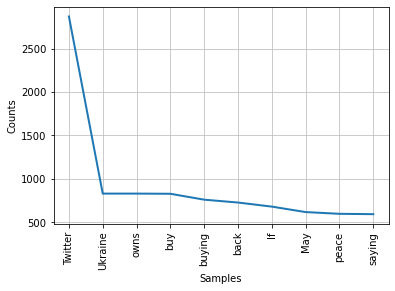

In [13]:
# get frequent words
a = Counter(text1).most_common(10)
print(a)
freq1 = nltk.FreqDist(text1)
freq1.plot(10);

## 2.What are the ten most popular hashtags?

### Step1: Create the hashtags list

In [14]:
hashtag=[]
for i in range(len(words1)):
    if "#" in words1[i] and words1[i] not in ["#Musk","#ElonMusk","#Elon"]:
        hashtag.append(words1[i].strip("…"))# to exclude the strings attached to the hashtags
print(hashtag)

['#BlockedProRussianPropagandists', '#D', '#Tesla', '#paypal', '#Ukrai', '#BlockedProRussianPropagandists', '#Ukraine', '#Starlink,', '#TheMaryTrumpShow', '#NerdAvengers', '#ElonSupportLunc', '#Tesla', '#Twitter', '#E', '#sondakika', '#haber', '#sondakikahaber', '#haberler', '#Starlink,', '#liberal', '#BlockedProRussianPropagandists', '#Twitter', '#ElonSupportLunc', '#Dogecoin', '#bitcoin', '#ElonSupportLunc', '#Twitter:', '#Selenskij', '#Melnyk', '#ElonSupportLunc', '#bitcoin', '#Ukraine', '#ElonSupportLunc', '#r4today', '#宁波资源', '#江北', '#Ukraine', '#TeslaBot', '#Twitter', '#musktwitter', '#news', '#новост', '#Твиттер', '#Маск', '#libertedexpression', '#bitcoin', '#Selenskyj', '#Putin', '#Ukraine', '#GenevaConventions', '#TheHague', '#D', '#Kiev', '#UkraineKrieg', '#Kriegstreiber', '#Twitter.', '#Twitter', '#proposition', '#réseau', '#临沂兰山', '#临沂', '#临沂资源', '#Ukraine', '#OAN', '#bitcoin', '#Dogecoin', '#Twitter', "#McDonald's", '#Beleggen', '#AEX', '#Aandelen', '#Beleggen', '#AEX', '#

### Step2: Get the frequency words and plot

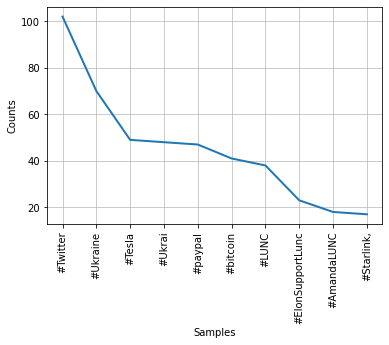

[('#Twitter', 102),
 ('#Ukraine', 70),
 ('#Tesla', 49),
 ('#Ukrai', 48),
 ('#paypal', 47),
 ('#bitcoin', 41),
 ('#LUNC', 38),
 ('#ElonSupportLunc', 23),
 ('#AmandaLUNC', 18),
 ('#Starlink,', 17)]

In [15]:
# get frequent wordsn and plot
freq2 = nltk.FreqDist(hashtag)
freq2.plot(10);
Counter(hashtag).most_common(10)

## 3.What are the ten most frequently mentioned usernames?

### Step1: Create the usernames list

In [16]:
usernames=[]
for i in range(len(words1)):
    if "@" in words1[i] and words1[i] != "@" and words1[i] not in ["@elonmusk:"]:
        usernames.append(words1[i].strip("@").strip(":"))
print(usernames)

['melissakchan', 'DougJBalloon', 'jonaskwakye_', 'blacksherif_🔥❤️', 'JackPosobiec', 'Proinvestor_com', 'Strandjunker', 'DougJBalloon', 'nikitheblogger', 'Vettelismo', 'Krokugoru', 'Strandjunker', 'NickAdamsinUSA', 'Public_Citizen', 'cb_doge', 'trishthedish117', 'manaf12hassan', 'OzraeliAvi', 'wolff_ernst', 'DC1776', 'TribelSocial', 'hankgreen', 'mybroadband', 'DarthPutinKGB', 'MrAndyNgo', 'elonmusk', 'DineshDSouza', 'DeathMetalV', 'Strandjunker', 'OzraeliAvi', 'umutaydin', 'M_Millerman', 'EFEnoticias', 'Travis_Flint_', 'jonaskwakye_', 'blacksherif_🔥❤️', 'DougJBalloon', 'WatcherGuru', 'RGVzoomin', 'OzraeliAvi', 'CrypticJacknife', 'kenklippenstein', 'Reuters', 'AP)', 'aintscarylarry', 'elonmusk', 'MrBeast', 'Dark_Matter2406', 'OmarLedezma6', 'Flores_1314', 'Jamille101_', 'OzraeliAvi', 'APompliano', 'Strandjunker', 'JustinAHorwitz', 'Krieger66362259', 'MayoIsSpicyy', 'Strandjunker', 'M_Millerman', 'mtracey', 'EFEnoticias', 'hankgreen', 'Travis_Flint_', 'RoiLopezRivas', 'realDonJTru1', 'Ke

### Step2: Get the frequency words and plot

[('OzraeliAvi', 472), ('Strandjunker', 394), ('JustinAHorwitz', 390), ('elonmusk', 313), ('RGVzoomin', 308), ('realDonJTru1', 294), ('hankgreen', 257), ('OccupyDemocrats', 251), ('oneunderscore__', 230), ('MNateShyamalan', 116), ('DougJBalloon', 111)]


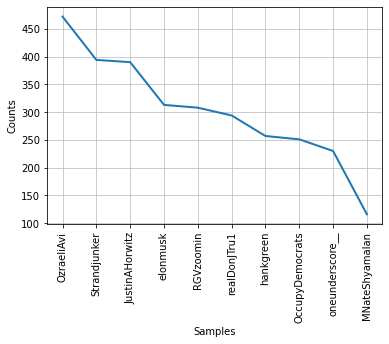

In [17]:
# get frequent words
print(Counter(usernames).most_common(11))
freq3 = nltk.FreqDist(usernames)
freq3.plot(10);

## 4.What are the three most common sources of tweets?

### Step1: Create the sources list

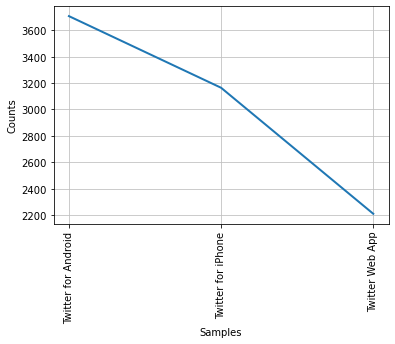

In [18]:
sources_of_tweets=[]
for i in range(len(streaming_result["tweets"])):
    sources_of_tweets.append(streaming_result["tweets"][i]["source"])
Counter(sources_of_tweets).most_common(3)
# get frequent words
freq4 = nltk.FreqDist(sources_of_tweets)
freq4.plot(3);

### Step2: Get the frequency words and plot

## 5.Create a line chart to show the time trend of tweet counts (number of tweets in a day (or an hour or a minute) depending on the collected data).

### Step1: Create a list of the time of posting for each tweet

In [ ]:
# Create a list of the time of posting for each tweet
time=[]
for i in range(len(streaming_result["tweets"])):
    time.append(streaming_result["tweets"][i]["created_at"])

from datetime import datetime
#_________________________________________________________________________________________________________________________# 
def time_handler(target_time):
    _date = datetime.strptime(target_time,"%Y-%m-%dT%H:%M:%S.%fZ")
    end_time = _date.strftime("%Y-%m-%d %H:%M:%S")
    return end_time
### Cited from:1234buzhidao56.(2022,July 26). python 时区时间转为标准时间，英文时间格式转成数字, part 1(part “一”), line 1 to line 12, CSDN, from https://blog.csdn.net/qq_53790158/article/details/125740615
### Copy right statement in English:This article is an original article by CSDN blogger "1234buzhidao56" and follows the CC 4.0 BY-SA copyright agreement. Please attach the original source link and this statement for reprinting.
### Copy right statament in original language:本文为CSDN博主「1234buzhidao56」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。
### Original link：https://blog.csdn.net/qq_53790158/article/details/125740615
#_________________________________________________________________________________________________________________________#

new_time = []
for i in time:
    new_time.append(time_handler(i))
#print(new_time)
hour_min = []
for i in new_time:
    no_day = i.split()
    hour_min.append(no_day[1])
#print(hour_min)
hm =[]
for i in hour_min:
    h1 = i.split(':')
    hm.append(h1[0]+h1[1])
print(hm)

### The code of defined function is cited from:1234buzhidao56.(2022,July 26). python 时区时间转为标准时间，英文时间格式转成数字, part 1(part “一”), line 1 to line 12, CSDN, from https://blog.csdn.net/qq_53790158/article/details/125740615
### Copy right statement in English:This article is an original article by CSDN blogger "1234buzhidao56" and follows the CC 4.0 BY-SA copyright agreement. Please attach the original source link and this statement for reprinting.
### Copy right statament in original language:本文为CSDN博主「1234buzhidao56」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。
### Original link：https://blog.csdn.net/qq_53790158/article/details/125740615

### Step2: Create a list of the time of posting for each tweet

{'0414': 84, '0415': 150, '0416': 139, '0417': 154, '0418': 162, '0419': 193, '0420': 154, '0421': 154, '0422': 151, '0423': 172, '0424': 184, '0425': 153, '0426': 155, '0427': 158, '0428': 151, '0429': 116, '0430': 146, '0431': 163, '0432': 172, '0433': 171, '0434': 142, '0435': 167, '0436': 152, '0437': 181, '0438': 148, '0439': 124, '0440': 129, '0441': 161, '0442': 180, '0443': 174, '0444': 151, '0445': 169, '0446': 144, '0447': 143, '0448': 150, '0449': 164, '0450': 147, '0451': 166, '0452': 142, '0453': 151, '0454': 158, '0455': 162, '0456': 170, '0457': 158, '0458': 170, '0459': 135, '0500': 197, '0501': 161, '0502': 126, '0503': 140, '0504': 134, '0505': 147, '0506': 170, '0507': 147, '0508': 192, '0509': 136, '0510': 150, '0511': 166, '0512': 118, '0513': 157, '0514': 143, '0515': 151, '0516': 128, '0517': 153, '0518': 164}
['0414', '0415', '0416', '0417', '0418', '0419', '0420', '0421', '0422', '0423', '0424', '0425', '0426', '0427', '0428', '0429', '0430', '0431', '0432', '0

Text(0.5, 1.0, 'time trend of tweet counts')

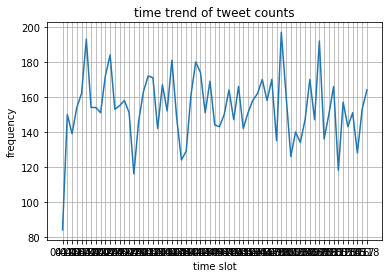

In [20]:
# To count the frequancy of each time
freq_dic=dict()
for i in sorted(hm):
    if i not in freq_dic.keys():
        freq_dic[i]=1
    else:
        freq_dic[i]+=1
print(freq_dic)
time_slot=list(freq_dic.keys())
frequency=[]
for k,v in freq_dic.items():
    frequency.append(freq_dic[k])
print(time_slot)
print(frequency)
# To make the plot
plt.plot(time_slot, frequency)
plt.grid(True)
plt.ylabel("frequency")
plt.xlabel("time slot")
plt.title('time trend of tweet counts')

## 6.Which are the three most influential tweets? A tweet’s influence score is the sum of “quote_count”, “reply_count”, “retweet_count”, “like_count”. These counts can be found in the “public_metrics” in the tweet data.

### Step1:Create lists for “quote_count”, “reply_count”, “retweet_count” and “like_count”

In [21]:
#create the quote count list
quote_count=[]
for i in range(len(streaming_result["tweets"])):
    quote_count.append(streaming_result["tweets"][i]["public_metrics"]["quote_count"])
print(quote_count)
#create the reply count list
reply_count=[]
for i in range(len(streaming_result["tweets"])):
    reply_count.append(streaming_result["tweets"][i]["public_metrics"]["reply_count"])
print(reply_count)
#create the retweet count list
retweet_count=[]
for i in range(len(streaming_result["tweets"])):
    retweet_count.append(streaming_result["tweets"][i]["public_metrics"]["retweet_count"])
print(retweet_count)
#create the like count list
like_count=[]
for i in range(len(streaming_result["tweets"])):
    like_count.append(streaming_result["tweets"][i]["public_metrics"]["like_count"])
print(like_count)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Step2:Create a dataframe for “quote_count”, “reply_count”, “retweet_count” and “like_count”

In [22]:
dic={"authors_id":authors_id,"quote_count":quote_count,"reply_count":reply_count,"retweet_count":retweet_count,"like_count":like_count}
lst1=["quote_count","reply_count","retweet_count","like_count"]
df1=pd.DataFrame(dic)
print(df1)

               authors_id  quote_count  reply_count  retweet_count  like_count
0              1872465721            0            0              0           0
1                15765206            0            0            338           0
2               149483869            0            0           2509           0
3               348426187            0            0           2202           0
4     1491937857619038217            0            0            862           0
...                   ...          ...          ...            ...         ...
9995  1522802109170790400            0            0             38           0
9996  1129876007417024512            0            0              0           0
9997             15228908            0            0           3275           0
9998             21965348            0            0          17824           0
9999  1069209446142877696            0            0             39           0

[10000 rows x 5 columns]


### Step3: Calculate influence score and create a new column named"influence_score" in dataframe 

In [23]:
df1["influence_score"]=df1[lst1].sum(axis = 1)
print(df1)

               authors_id  quote_count  reply_count  retweet_count  \
0              1872465721            0            0              0   
1                15765206            0            0            338   
2               149483869            0            0           2509   
3               348426187            0            0           2202   
4     1491937857619038217            0            0            862   
...                   ...          ...          ...            ...   
9995  1522802109170790400            0            0             38   
9996  1129876007417024512            0            0              0   
9997             15228908            0            0           3275   
9998             21965348            0            0          17824   
9999  1069209446142877696            0            0             39   

      like_count  influence_score  
0              0                0  
1              0              338  
2              0             2509  
3              

### Step4: Sort the data frame by influence score

In [24]:
most_influential_tweets=df1.sort_values("influence_score",ascending=False)[lst1+["influence_score","authors_id"]][:3]
print(most_influential_tweets)

      quote_count  reply_count  retweet_count  like_count  influence_score  \
6180            0            0          30643           0            30643   
4112            0            0          30643           0            30643   
2332            0            0          30643           0            30643   

      authors_id  
6180   554565840  
4112  4776549743  
2332  1339433486  


### Step5: Print the three most influential tweets

In [25]:
index_tweets=most_influential_tweets.index.tolist()
print(index_tweets)
for i in index_tweets:
    pprint(streaming_result["tweets"][i]['text'])

[6180, 4112, 2332]
('RT @Strandjunker: Just for those who may be a little confused: Elon Musk did '
 'not generously donate his Starlink satellite internet to Ukrai…')
('RT @Strandjunker: Just for those who may be a little confused: Elon Musk did '
 'not generously donate his Starlink satellite internet to Ukrai…')
('RT @Strandjunker: Just for those who may be a little confused: Elon Musk did '
 'not generously donate his Starlink satellite internet to Ukrai…')


## 7.Who are the three most vocal authors on the keyword? In other words, who are the most frequently tweeting authors in the tweet data? 

### Step1: Use method json_normalization() to parse the streaming_result into dataframe with the lowest unit in the original dictionary.

In [26]:
tweet = pd.json_normalize(streaming_result['tweets'])
tweet.head()

author_id  possibly_sensitive  \
0           1872465721               False   
1             15765206               False   
2            149483869               False   
3            348426187               False   
4  1491937857619038217               False   

                                                text  \
0                            https://t.co/Yxxk38MCay   
1  RT @melissakchan: Don’t get how Elon Musk can ...   
2  RT @DougJBalloon: Inside Elon Musk’s savvy que...   
3  RT @jonaskwakye_: Listen to what Elon Musk had...   
4  RT @JackPosobiec: When Elon Musk takes over Tw...   

                 created_at lang edit_history_tweet_ids                   id  \
0  2022-10-05T05:18:59.000Z  zxx  [1577528758650667008]  1577528758650667008   
1  2022-10-05T05:18:59.000Z   en  [1577528757598015490]  1577528757598015490   
2  2022-10-05T05:18:59.000Z   en  [1577528755765272576]  1577528755765272576   
3  2022-10-05T05:18:58.000Z   en  [1577528755265966080]  1577528755265966080   
4  2022-10-05T05:18:58.000Z   en  [1577528751855992832]  1577528751855992832   

                source                                      entities.urls  \
0      Twitter Web App  [{'start': 0, 'end': 23, 'url': 'https://t.co/...   
1     Tweetbot for iΟS                                                NaN   
2      Twitter Web App                                                NaN   
3   Twitter for iPhone                                                NaN   
4  Twitter for Android                                                NaN   

   public_metrics.retweet_count  ...  \
0                             0  ...   
1                           338  ...   
2                          2509  ...   
3                          2202  ...   
4                           862  ...   

                                 context_annotations  \
0                                                NaN   
1  [{'domain': {'id': '46', 'name': 'Business Tax...   
2  [{'domain': {'id': '46', 'name': 'Business Tax...   
3  [{'domain': {'id': '10', 'name': 'Person', 'de...   
4  [{'domain': {'id': '10', 'name': 'Person', 'de...   

                                   entities.mentions  \
0                                                NaN   
1  [{'start': 3, 'end': 16, 'username': 'melissak...   
2  [{'start': 3, 'end': 16, 'username': 'DougJBal...   
3  [{'start': 3, 'end': 16, 'username': 'jonaskwa...   
4  [{'start': 3, 'end': 16, 'username': 'JackPoso...   

                                entities.annotations in_reply_to_user_id  \
0                                                NaN                 NaN   
1  [{'start': 32, 'end': 40, 'probability': 0.975...                 NaN   
2  [{'start': 25, 'end': 33, 'probability': 0.394...                 NaN   
3  [{'start': 33, 'end': 41, 'probability': 0.984...                 NaN   
4  [{'start': 23, 'end': 31, 'probability': 0.953...                 NaN   

  entities.hashtags attachments.media_keys entities.cashtags  \
0               NaN                    NaN               NaN   
1               NaN                    NaN               NaN   
2               NaN                    NaN               NaN   
3               NaN                    NaN               NaN   
4               NaN                    NaN               NaN   

  withheld.copyright withheld.country_codes geo.place_id  
0                NaN                    NaN          NaN  
1                NaN                    NaN          NaN  
2                NaN                    NaN          NaN  
3                NaN                    NaN          NaN  
4                NaN                    NaN          NaN  

[5 rows x 24 columns]

### Step2: Use groupby() and count() method to count the frequency of each author id in the tweets collected, and create a column named “count” to store the results.

In [27]:
tweet1 = tweet.groupby('author_id')['author_id'].count().reset_index(name='counts')
tweet1.head()

author_id  counts
0  1000391498347655168       1
1  1000767798392467456       1
2            100077645       1
3  1000821357578342400       1
4  1001127907136344065       1

### Step3: Sorted the dataframe by the value of column “count” and slice the top 3 author ids

In [33]:
tweet2 = tweet1.sort_values('counts',ascending = False)[:3]
tweet3 = tweet2['author_id'].tolist()
print(tweet3)

['34135329', '1069209446142877696', '1213646996940017666']


In [40]:
most_influential_authors = []

for i in author_infomation:
    try:
        if i['id'] in tweet3:
            most_influential_authors.append(i['username'])
    except TypeError:
        continue
print(most_influential_authors)

['EvaCaroMadrid', 'jcdaley', 'DemeKhadim1']


## 8.Who are the three most influential authors? A user’s influence score is the sum of “followers_count”, “following_count”, “listed_count”. “tweet_count” in the author data.

### Step1: Create lists for“followers_count”, “following_count”, “listed_count”, “tweet_count”by using the for loop in author_information.

In [39]:
print(author_infomation[0])

{'name': 'Josie', 'description': 'Protecting American democracy from those who would do it harm one tweet at a time!', 'verified': False, 'created_at': '2016-08-25T15:12:54.000Z', 'location': 'Chicago, IL', 'id': '768828506134482944', 'public_metrics': {'followers_count': 197, 'following_count': 403, 'tweet_count': 8007, 'listed_count': 5}, 'username': 'JosieLx33'}


In [41]:
#create the followers count list
followers_count=[]
for i in range(len(author_infomation)):
    try:
        followers_count.append(author_infomation[i]["public_metrics"]["followers_count"])
    except TypeError:
        continue
print(followers_count)

#create the following count list
following_count=[]
for i in range(len(author_infomation)):
    try:
        following_count.append(author_infomation[i]["public_metrics"]["following_count"])
    except TypeError:
        continue
print(following_count)

#create the listed_count list
listed_count=[]
for i in range(len(author_infomation)):
    try:
        listed_count.append(author_infomation[i]["public_metrics"]["listed_count"])
    except TypeError:
        continue
print(listed_count)

#create the tweet count list
tweet_count=[]
for i in range(len(author_infomation)):
    try:
        tweet_count.append(author_infomation[i]["public_metrics"]["tweet_count"])
    except TypeError:
        continue
print(tweet_count)

#create the username list
username=[]
for i in range(len(author_infomation)):
    try:
        username.append(author_infomation[i]["username"])
    except TypeError:
        continue
print(username)
print(username.count("EconomicTimes"))

[197, 614, 154, 552, 15941, 3299, 307, 1299, 1586, 25, 321, 21, 3981, 854, 156, 41, 948, 584, 3124, 630, 273, 82, 498, 4146, 56, 5585, 2459, 302, 2189, 910, 223, 462, 1942, 335, 2231, 1133, 187, 120, 6, 3018, 164, 34, 2253, 7, 556, 646, 284, 9608, 6495, 486, 11684, 10, 37, 3, 6, 939, 300, 29, 2513, 443, 1798, 260, 120, 1456, 128, 1909, 480, 498, 1647, 1117, 80, 1959, 5, 6, 249, 1901, 44, 1535, 659, 1250, 12, 1222, 74, 9157, 148, 542, 433, 688, 1227, 139, 43, 897, 10, 9340, 458, 345, 10512, 487, 753, 161, 512, 110, 3, 350, 52, 2903, 498, 413, 1055, 1708, 192, 1780, 762, 276, 919, 1583, 297, 13, 127, 9, 2, 2101, 8, 59513, 1, 4502, 365, 24, 463, 214, 13342, 89, 123, 104, 321, 261, 309, 133, 22, 3185, 683, 1206, 307, 5, 3120, 173, 565, 244, 3449, 139, 710, 1821, 83, 295, 36, 125, 2753, 1891, 5384, 459, 852, 38, 310, 2, 115, 70, 1881, 30124, 12019, 1068, 9, 58, 51, 889, 202, 49, 7631, 154, 91, 386, 130, 822, 2828, 17, 1197, 841, 22, 1346, 3490, 85, 23, 686, 773, 31, 86, 65, 20893, 162, 521,

### Step2: Create a dataframe for“followers_count”, “following_count”, “listed_count”. “tweet_count”.

In [42]:
dic1={"username":username,"followers_count":followers_count,"following_count":following_count,"listed_count":listed_count,"tweet_count":tweet_count}
lst2=["followers_count", "following_count", "listed_count", "tweet_count"]
df2=pd.DataFrame(dic1)
print(df2)

             username  followers_count  following_count  listed_count  \
0           JosieLx33              197              403             5   
1       AlexKubile100              614             1405             9   
2            pattiang              154              448             0   
3       Dr_AbdulSamad              552              891             2   
4     darknessn2light            15941            17433            11   
...               ...              ...              ...           ...   
8398  Kenneth40708724             1575             1863             8   
8399       ABTurner21              326              385             0   
8400  BeverleyABaird1              349              962             0   
8401      2011teacher             1262             1613           110   
8402         BasedSol              341              812             2   

      tweet_count  
0            8007  
1            9571  
2            8833  
3           16614  
4          196209  
...

### Step3: Calculate influence score and create a new column named"author_influence_score" in dataframe.

In [43]:
df2["author_influence_score"]=df2[lst2].sum(axis = 1)
print(df2)

             username  followers_count  following_count  listed_count  \
0           JosieLx33              197              403             5   
1       AlexKubile100              614             1405             9   
2            pattiang              154              448             0   
3       Dr_AbdulSamad              552              891             2   
4     darknessn2light            15941            17433            11   
...               ...              ...              ...           ...   
8398  Kenneth40708724             1575             1863             8   
8399       ABTurner21              326              385             0   
8400  BeverleyABaird1              349              962             0   
8401      2011teacher             1262             1613           110   
8402         BasedSol              341              812             2   

      tweet_count  author_influence_score  
0            8007                    8612  
1            9571                  

### Step4: Sort by influence score and print 3 most influential authors.

In [44]:
most_influential_authors=df2.sort_values("author_influence_score",ascending=False)[["username","author_influence_score"]][:3]
print(most_influential_authors)

        username  author_influence_score
3025  test5f1798                50725451
2973     Reuters                26619337
4968         WSJ                20743501


In [45]:
# Print the three most influential authors
index_influential_authors=most_influential_authors.index.tolist()
print(index_influential_authors)
for i in index_influential_authors:
    pprint(author_infomation[i])

[3025, 2973, 4968]
{'created_at': '2011-11-10T21:35:27.000Z',
 'description': 'Western Canada living. Full time RV living. #FreeDumbConvoy',
 'id': '409529739',
 'location': 'Vancouver Island, BC Canada',
 'name': 'Retired Northern Resistor 🇨🇦🇳🇴🧑\u200d🏫 ⛺️',
 'public_metrics': {'followers_count': 5050,
                    'following_count': 5088,
                    'listed_count': 2,
                    'tweet_count': 2205},
 'username': 'prairiesailors',
 'verified': False}
{'created_at': '2021-11-27T05:14:34.000Z',
 'description': '#NFT | #BNB | #SOLANA | #BTC | #BSC | #ETH',
 'id': '1464462491560591360',
 'name': 'Cbubbles',
 'public_metrics': {'followers_count': 47,
                    'following_count': 44,
                    'listed_count': 9,
                    'tweet_count': 301},
 'username': 'hashbubbles2',
 'verified': False}
{'created_at': '2020-12-13T14:14:04.000Z',
 'description': '',
 'id': '1338124764100108294',
 'location': 'München ',
 'name': 'FRED',
 'public_metr

# Question C

### Step1: Create a list that exclude the stop words

In [46]:
text2 = [] # our accumulator list
for i in words1:
    if i not in stopwords and len(i) > 1 and i not in ['de','RT','u,']:# to exclude stop words
        text2.append(i)
# exclude the elements with meaningless url elements
text3= []
for i in text2:
    if "https://t.co/" not in i:
        text3.append(i)

### Step2: Create a text to contain all the words

In [47]:
text4=""
for i in text3:
    text4=text4+" "+i

In [143]:
print(text4)

 @melissakchan: Don’t get Elon Musk push Russian talking points, obsess creating “everything” app he’s compared China’… @DougJBalloon: Inside Elon Musk’s savvy quest turn $40 billion company 4chan. @jonaskwakye_: Listen Elon Musk say @blacksherif_🔥❤️ don’t think he’s seen this… lets retweet till sees guy… @JackPosobiec: When Elon Musk takes Twitter begin search people lost along way @Proinvestor_com: Twitter: Elon Musk: Nogen underskrifter er dyrere end andre, men fællesnævneren er er bindende @Strandjunker: Just may little confused: Elon Musk generously donate Starlink satellite internet Ukrai… @DougJBalloon: Inside Elon Musk’s savvy quest turn $40 billion company 4chan. @nikitheblogger: Elon Musk macht einen Vorschlag für Frieden und Grüne gehen auf ihn los, als wäre er der Teufel Person. Was genau is… @Vettelismo #BlockedProRussianPropagandists Solovyov advocates going front line applying death penalty family friends go war. He also defends sending Russian oligarchs front line, incl

### Step3: Feed the text into the wordcloud module and display the generated image

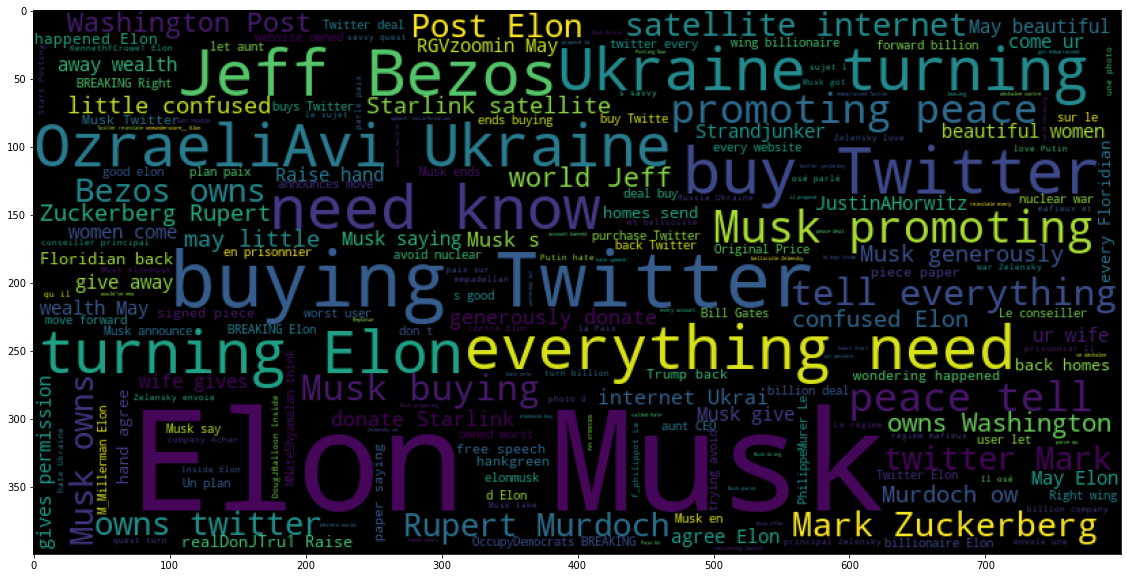

In [144]:
# lower max_font_size
wordcloud = WordCloud(width=800, height=400).generate(text4) # note that text is a string, not a list

# Display the generated image:
plt.figure(figsize=(20,10)) # set up figure size
plt.imshow(wordcloud) # word cloud image show
plt.axis("on") # turn on axis
plt.savefig('my_word_cloud.png') # save as PNG file
plt.savefig('my_word_cloud.pdf') # save as PDF file
plt.show()  # show in Jupyter notebook

# Question D

## 1.What are the average polarity and subjectivity scores?

In [48]:
#construct the polarity and subjectivity scores list
pol_list=[]
sub_list=[]
for i in text:
    pol_list.append(TextBlob(i).sentiment.polarity)
    sub_list.append(TextBlob(i).sentiment.subjectivity)
ave_pol_score=sum(pol_list)/len(pol_list)
ave_sub_score=sum(sub_list)/len(sub_list)
print("The average polarity score is " + str(ave_pol_score))
print("The average subjectivity score is " + str(ave_sub_score))

The average polarity score is 0.04407779586492846
The average subjectivity score is 0.25105026799496444


## 2.Visualize the polarity and subjectivity score distributions using histograms, where X-axis is the score and Y-axis is the tweet count in the score bin. In total, there should be 2 histograms for this task.

### (1) To visualize the distributions of polarity score

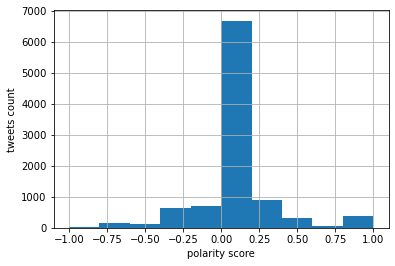

In [21]:
plt.hist(pol_list, bins=10) #, normed=1, alpha=0.75)
plt.xlabel('polarity score')
plt.ylabel('tweets count')
plt.grid(True)
plt.savefig('polarity.pdf')
plt.show()

### (2) To visualize the distributions of subjectivity score

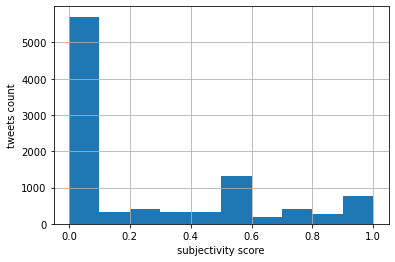

In [22]:
plt.hist(sub_list, bins=10) #, normed=1, alpha=0.75)
plt.xlabel('subjectivity score')
plt.ylabel('tweets count')
plt.grid(True)
plt.savefig('subjectivity.pdf')
plt.show()

## 3.Based on the polarity scores, what are the most positive and negative tweets on the keyword? Why is the author happy/angry on the topic? If there are multiple tweets with same sentiment scores, please pick 2-3 tweets among them.

### Step1: Test whether there are numtiple tweets with same sentiment scores

In [96]:
print(max(pol_list))
print(min(pol_list))
print(pol_list.count(max(pol_list)))
print(pol_list.count(min(pol_list)))
print([i for i,j in enumerate(pol_list) if j==1.0])
print([i for i,j in enumerate(pol_list) if j==-1.0])

1.0
-1.0
23
9
[595, 1000, 1188, 1612, 2308, 2323, 2746, 2977, 3056, 3867, 4378, 5024, 5639, 5962, 6267, 6288, 7325, 7746, 7999, 8029, 8463, 8511, 8558]
[159, 1522, 4377, 4869, 7148, 7461, 7650, 8174, 9087]


 The results told us that there are 23 tweets with sentiment scores value at 1.0 and 9 tweets with sentiment scores value at -1.0.

### Step2: To print the 3 most positive tweets

In [64]:
print("The most negative tweet is:",streaming_result["tweets"][595]["text"])
print("The author id is:",streaming_result["tweets"][595]["author_id"])
print("The most negative tweet is:",streaming_result["tweets"][5639]["text"])
print("The author id is:",streaming_result["tweets"][5639]["author_id"])
print("The most negative tweet is:",streaming_result["tweets"][8558]["text"])
print("The author id is:",streaming_result["tweets"][8558]["author_id"])

595
The most positive tweet is: Ram Gopal Varma Extends Sexist Dussehra 2022 Greetings to Followers, That They Get Elon Musk’s Wealth and Beautiful Women with Wife’s Permission! https://t.co/srimC7BjxA
The score is:1.0
The author id is: 185115193
159
The most negative tweet is: RT @supermarETH: ELON MUSK WITH THIS INSANE UPDATE🚨🚨🚨🚨 

Hit that like and retweet button to see🤫
The score is:-1.0
The author id is: 1479295916830081028
The most negative tweet is: RT @MariaSchenetzke: @oneunderscore__ @jaredlholt Make Putin loaned him some money   Putin was very happy about Elon Musk’s tweet yesterday
The author id is: 4075396512
The most negative tweet is: RT @chicago_glenn: Elon Musk is the best thing that’s ever happened to Twitter! 💗 @elonmusk https://t.co/LeUyG6Zmhl
The author id is: 1512746965272047622
The most negative tweet is: Need Elon Musk to kill this Twitter swipe up video update, it's terrible
The author id is: 536008303
The most negative tweet is: @KavalAuthorActs Purging accoun

### Step3: To print the 3 most negative tweets

In [86]:
print("The most negative tweet is:",streaming_result["tweets"][159]["text"])
print("The author id is:",streaming_result["tweets"][159]["author_id"])
print("The most negative tweet is:",streaming_result["tweets"][8174]["text"])
print("The author id is:",streaming_result["tweets"][8174]["author_id"])
print("The most negative tweet is:",streaming_result["tweets"][9087]["text"])
print("The author id is:",streaming_result["tweets"][9087]["author_id"])

The most negative tweet is: RT @supermarETH: ELON MUSK WITH THIS INSANE UPDATE🚨🚨🚨🚨 

Hit that like and retweet button to see🤫
The author id is: 1479295916830081028
The most negative tweet is: Need Elon Musk to kill this Twitter swipe up video update, it's terrible
The author id is: 536008303
The most negative tweet is: @KavalAuthorActs Purging accounts before the buyout from Boring company ( Elon Musk )
The author id is: 29993717


# Question E

## 1.Please describe the insights you gained from the analyses. 

**The preliminary analysis tells us that:**

Recently, Elon Musk has been involved in several controversial or popular topics: Twitter Acquisition, Ukraine War, LUNC and Bitcoin. He offered to buy Twitter for original price, weeks before trial following his moves in July to terminate his planned $44 billion purchase; He has gotten into a Twitter tussle with Ukrainian President Volodymyr Zelenskyy after the tech billionaire floated a divisive proposal to end Russia’s invasion. Also, as one of the most influential opinion leaders of Bitcoin, he is often tied with the discussion of Bitcoin, especially debate about the LUNC. People are asking his opinion since every comment he made on Bitcoin will probably significantly affect the price of one certain Bitcoin.

**The sentiment analysis tells us that:**

The average polarity score is 0, and the distribution of the polarity score is concentrated near 0, which means the twitter users on average hold neutral attitudes towards Elon Musk’s recent speeches.The average subjectivity score is 0.25, which means that people have mild subjectivity on the controversial topics.

**The words cloud tells us that:** 

The discussion on Elon Musk may have spillover effect on other CEOs of the famous internet companies in North America, namely users may have the habit or mindset to group people with similar characteristics together in their mind, and if a person has a lot of news on internet, the users will automatically think of other persons with similar characteristics, even though they have nothing to do with the news directly. This is actually a common phenomenon on social media platform.

## 2.Think about a broader social media project you may conduct using more datasets such as intermetal corporate datasets (e.g., customer transactions, firm financials, HR data) as well as other unstructured data (e.g., business/legal documents, social media pictures, YouTube/TikTok videos, etc.). I look forward to seeing your unique and creative perspectives. 

**Topic**: How will stakeholder’s sentiment affect the performance of companies.

**Datasets**: internal corporate datasets(financials,customer transaction,HR data); structured and unstructured data on social media platform about the companies.

**Content**:

**Part A**: Data Collection

Using python to collect structured and unstructured data concerning about stakeholder’s sentiment towards companies from social media platform.

**Part B**: Data Analysis

Parse the structured and unstructured data to quantify the sentiment of stakeholders on companies operation.

**Part C**: Hypothesis testing

Propose meaningful hypothesis to be tested, for example:

(1)Positive sentiment from stakeholders will improve the financial records of company.

(2)Positive sentiment from stakeholder will increase customer transaction.

(3)Positive sentiment from stakeholder will increase employee retention ration.

(4)Build econometrical model for the hypothesis

Use python to run the regression models to test hypothesis.

**Insights and Conclusions**